In [1]:
from numba import float32,int32,int8,jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32,xoroshiro128p_uniform_float64
from numba.cuda.random import xoroshiro128p_normal_float32
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from util import *
import torch
from torch import nn

# Using the decompression functions from data generation

In [2]:
@cuda.jit
def decompress2D(inn,states):
    """Inverse function of compress
    Note: This is slightly changed to work with the correct tensor shape"""
    sz,_,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n][0]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        state[x][y]=1&(num>>bit)

@cuda.jit
def decompress1D(inn,states):
    """Similar to decompress 2D but instead of being an inverse to compress it squishes the 2D
    array output into a 1D array (which is now in a snake pattern)
    if states has shape [N,X,1] then out should have shape [M,Z/8]
    and the blocks/threads should have shape [N,Z/8]
    Here Z=X*Y where each state has shape [X,Y] on a 2D grid
    
    Note: This is slightly changed to work with the correct tensor shape
    """
    #n is which grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        #get each value in 1d
        state[idx][0]=1&(num>>bit)

In [3]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


# Settings for which model to train (or to just test)

In [4]:
#bsize=1024
#N=32

bsize=2048
N=16

#bsize=4096
#N=8

B=0.4407

modeltype='2d'

epoch = 1

TRAINING=False

# Implementing a simple RNN model

In [5]:
class RNN(nn.Module):
    def __init__(self,device=device, **kwargs):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=1,hidden_size=128,batch_first=True)
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        self.device=device
        self.to(device)
    def forward(self, input):
        # h0 has shape [N,L,H]
        h0=torch.zeros([1,input.shape[0],128]).to(device)
        out,h=self.rnn(input,h0)
        return self.lin(out)

# Using a 2D RNN

https://github.com/FlorianPfisterer/2D-LSTM-Seq2Seq/blob/master/model/lstm2d_cell.py

THIS IMPLEMENTATION LEAKS GPU MEMORY SOMEWHERE!!!

In [6]:
class LSTM2dCell(nn.Module):
    """
    A 2d-LSTM Cell that computes it's hidden state and cell state based on
        - an input x
        - the previous horizontal hidden and cell state
        - the previous vertical hidden and cell state
    Args:
        input_dim: the input dimension (i.e. second dimension of x)
        state_dim: dimension of the hidden and cell state of this LSTM unit
        device: the device (CPU / GPU) to run all computations on / store tensors on
    """

    def __init__(self, input_dim, state_dim,N, device):
        super(LSTM2dCell, self).__init__()
        self.input_dim = input_dim
        self.state_dim = state_dim
        self.device = device

        # input to state
        self.W_x = nn.Linear(self.input_dim, self.state_dim * 5).to(self.device)
        # previous horizontal hidden state to state
        self.W_hor = nn.Linear(self.state_dim, self.state_dim * 5).to(self.device)
        # previous vertical hidden state to state
        self.W_ver = nn.Linear(self.state_dim, self.state_dim * 5).to(self.device)
        
        self.N=N
        self.lin = nn.Sequential(
                nn.Linear(state_dim,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            ).to(device)
        self.setup()
    def forward_pass(self, x, s_prev_hor, s_prev_ver, c_prev_hor, c_prev_ver):
        """
        Forward pass of the 2d-LSTM Cell at horizontal step j and vertical step i (to compute c_ji and s_ji)
        Args:
            x: (batch x input_dim) input at horizontal step j
            s_prev_hor: (batch x state_dim) hidden state of cell at previous horizontal step j-1, same vertical step i
            s_prev_ver: (batch x state_dim) hidden state of cell at previous vertical step i-1, same horizontal step j
            c_prev_hor: (batch x state_dim) cell state of cell at previous horizontal step j-1, same vertical step i
            c_prev_ver: (batch x state_dim) cell state of cell at previous vertical step i-1, same horizontal step j
        Returns:
            c: (batch x state_dim) next cell state (c_ji)
            s: (batch x state_dim) next hidden state (s_ji)
        """
        pre_activation = self.W_x(x) + self.W_hor(s_prev_hor) + self.W_ver(s_prev_ver)
        gates = pre_activation[:, :4*self.state_dim].sigmoid()

        # retrieve input, forget, output and lambda gate from gates
        i = gates[:, 0*self.state_dim:1*self.state_dim]
        f = gates[:, 1*self.state_dim:2*self.state_dim]
        o = gates[:, 2*self.state_dim:3*self.state_dim]
        l = gates[:, 3*self.state_dim:4*self.state_dim]

        c_candidate = pre_activation[:, 4*self.state_dim:].tanh()
        c = f * (l * c_prev_hor + (1 - l) * c_prev_ver) + c_candidate * i
        s = c.tanh() * o

        return c, s
        
    def setup(self):
        """Sets up the structure that tells the rnn how to propogate the vertical and horizontal states.
        Notably: X stores where to look for the previous rnn state in the vertical direction
                 Y stores where to look for the previous rnn state in the horizontal direction
                 Z stores where to save the current rnn output
        """
        print(self.N**2-1)
        N=self.N
        self.X=np.zeros([N**2-1],dtype=np.int64)
        self.Y=np.zeros([N**2-1],dtype=np.int64)
        Z=np.arange(N**2).reshape(N,N)
        Z[1::2,:]=Z[1::2,::-1]
        #Z is in the snake pattern
        Z=Z.reshape(N**2)[:N**2-1]
        #pad states outside with the index of the starting state
        states=np.pad(np.arange(N**2).reshape(N,N),[1,1],constant_values=N*(N-1))
        for idx in range(N**2-1):
            self.Y[idx]=states[Z[idx]//N+1,Z[idx]%N+2*((idx//N)%2)]
            self.X[idx]=states[Z[idx]//N,Z[idx]%N+1]
        self.Z=Z
        
    def forward(self,input):
        N=self.N
        X,Y,Z=self.X,self.Y,self.Z
        #set up array to store hidden states
        H,C= [True]*N**2,[True]*N**2
        #set the starting state to zero
        H[N*(N-1)]=C[N*(N-1)]=torch.zeros([input.shape[0],self.state_dim],device=device)
        out = torch.zeros(input.shape,device=self.device)
        read=[]
        for idx in range(N**2-1):
            #get horizontal input states
            hx,cx=H[X[idx]],C[X[idx]]
            #get vertical input states
            hy,cy=H[Y[idx]],C[Y[idx]]
            #get output states
            cnext,hnext=self.forward_pass(input[:,idx,:],hx,hy,cx,cy)
            #store output states for later use
            C[Z[idx]],H[Z[idx]] = cnext,hnext
            #apply linear layer
            out[:,idx,:]=self.lin(hnext)
        return out


# Visualizing 2D RNN Propogation

Note 1: The bottom left (in state sources) stores the zero state

Note 2: To get the position of the hidden state input in the propogation figures, just look for the cell in state sources with the matching color

15


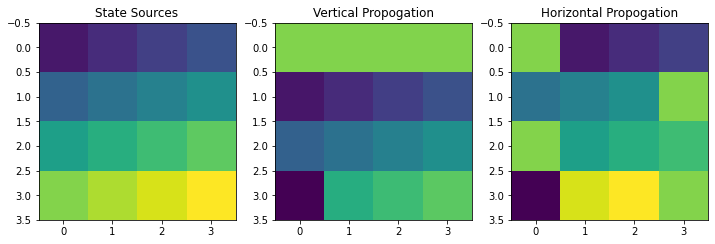

In [7]:
plt.rcParams["figure.figsize"]= [12,4]
tst = LSTM2dCell(1,128,4,device)
X,Y = np.zeros(4**2)-1,np.zeros(4**2)-1
X[tst.Z]=tst.X
Y[tst.Z]=tst.Y
X=X.reshape(4,4)
Y=Y.reshape(4,4)
Z=np.arange(16).reshape(4,4)

fig,(a1,a2,a3)=plt.subplots(1,3)
a1.imshow(Z,vmax=15,vmin=-1)
a1.set_title("State Sources")
a2.imshow(X,vmax=15,vmin=-1)
a2.set_title("Vertical Propogation")
a3.imshow(Y,vmax=15,vmin=-1)
a3.set_title("Horizontal Propogation")
plt.show()

# Blocked CNN :)

In [8]:
class BlockedCNN(nn.Module):
    def __init__(self,device,N):
        super(BlockedCNN, self).__init__()
        self.N=N
        tmp=np.arange(N**2).reshape([N,N])
        tmp[1::2,:]=tmp[1::2,::-1]
        plt.imshow(tmp)
        plt.show()
        tmp2 = np.array([[tmp<=i for i in range(N**2-1)]])

        self.mul=torch.tensor(tmp2).to(device).unsqueeze(2)
        self.add=torch.tensor(tmp2-1).to(device).unsqueeze(2)
        
        print(self.add.shape)
        
        self.net = nn.Sequential(
                nn.Conv2d(1,8,N//4,padding='same',padding_mode ='circular'),
                nn.ReLU(True),
                nn.MaxPool2d(2),
                nn.Conv2d(8,16,N//4,padding='same',padding_mode ='circular'),
                nn.ReLU(True),
                nn.MaxPool2d(2),
                nn.Flatten(),
                #Insize is 256, outsize is 10
                nn.Linear(N**2,256),
                nn.ReLU(True),
                nn.Linear(256,1),
                nn.Sigmoid(),
            )
        self.to(device)
    def forward(self, input):
        blocked=input.unsqueeze(1)*self.mul+self.add
        a,b,c,d,e=blocked.shape
        netin = blocked.reshape([a*b,c,d,e])
        netout = self.net(netin)
        ab,c2 = netout.shape
        return netout.reshape([a,b,c2])

# Setting Parameters for what model to train

In [9]:
traindata = np.load('data/traindata%d-%d.npy'%(N,B*10000))

In [10]:
#traindata = traindata[:traindata.shape[0]//5]

In [11]:
traindata = traindata[np.random.permutation(traindata.shape[0])]
traindata.shape

(51200000, 32)

In [12]:
#traindata=traindata[:512000]

# Making sure the shape of everything lines up

In [13]:
batch=torch.zeros([bsize,N*N,1]).to(device)
decompress1D[(bsize,N//2),(1,N//4)](traindata[0:bsize],batch)
if modeltype=='CNN':
    data=torch.zeros([bsize,1,N,N]).to(device)
    decompress2D[(bsize,N//2),(1,N//4)](traindata[0:bsize],data)
else:
    data=batch[:,:-1,:]
label=batch[:,1:,:]
print(data.shape,label.shape)
print(data[:,:,0])

torch.Size([2048, 255, 1]) torch.Size([2048, 255, 1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 0., 1., 1.]], device='cuda:0')


# Initialize the network

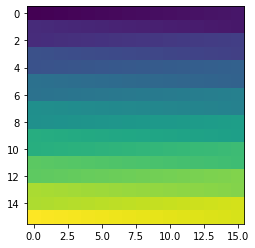

torch.Size([1, 255, 1, 16, 16])
255
torch.Size([2048, 255, 1])


In [14]:


typedict={'CNN':BlockedCNN(device,N),'2d':LSTM2dCell(1,128,N,device),'':RNN()}

net = typedict[modeltype]
with torch.no_grad():
    print(net(data).shape)

#training parameters
lr = 1e-4 *(bsize/2048)
beta1 = 0.9
beta2=0.999
#Using adam to optimize
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)

# Make sure to use a loss which will give you probabilities in your predictions.

I know L2 loss and Binary Cross Entropy Loss will do this

In [15]:
Loss = nn.BCELoss()
losses=[]
validation=[]
vidx= traindata.shape[0]//bsize-1
print(vidx)

24999


# Network actually trains in a few epochs

In [16]:

#set the last batch to validation
#this is a super lazy validation set 
if TRAINING:
    count=0
    for i in range(epoch):
        #decided the last batch is validation 
        p = np.random.permutation(traindata.shape[0]//bsize)
        t=time.time()
        for idx in p:
            #decompress the traindata with the gpu
            decompress1D[(bsize,N//2),(1,N//4)](traindata[bsize*idx:bsize*(idx+1)],batch)
            #starting N**2-1 are inputs
            if modeltype=='CNN':
                decompress2D[(bsize,N//2),(1,N//4)](traindata[bsize*idx:bsize*(idx+1)],data)
            else:
                data=batch[:,:-1,:]
            #ending N**2-1 are predictions
            real=batch[:,1:,:]

            pred = net(data)
            loss = Loss(pred,real)
            net.zero_grad()
            if idx!=vidx:
                loss.backward()
                optimizer.step()
                losses.append(loss.cpu().item())
            else:
                validation.append(loss.cpu().item())
            count+=1
            if (count%500)==0:
                print("|",end="")
                plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
                plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
                plt.yscale("log")
                plt.savefig("Loss.png")
                plt.close()
                torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
        if epoch//100==0 or i%(epoch//100)==0:
            print("%.5f, %ds"%(np.mean(losses[-p.size-1:]),time.time()-t),end="| ")
            torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))

In [17]:
#print(np.where(p==idx))

In [18]:
if TRAINING:
    torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))

# Plotting training loss

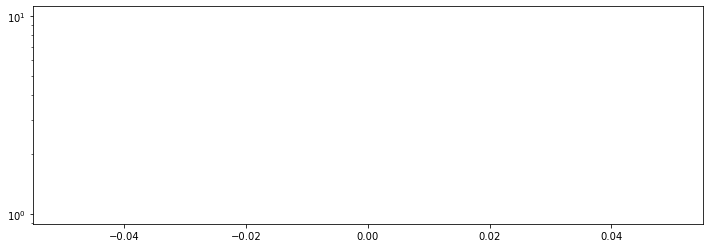

In [19]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()
plt.close()

# Testing Our Output

In [20]:
testdata=np.load('data/testdata%d.npy'%N)

# Computing True and Predicted Energies

Note: To go from probability to energy we look at the relation:

$P(s)=\frac{exp(-\beta H(s))}{Z} = \frac{1}{2} \prod_{i=2}^{N^2}p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1) $

So

$ln(P(s)) = -\beta H(s) - ln(Z) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]$

$-\beta H(s) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]+ln(Z)$

$H(s) = \frac{ln(2)- \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]}{\beta }-\frac{ln(Z)}{\beta}$

In [21]:
@cuda.jit
def IsingEnergy(grids,E):
    """Compute Energy of 2D ising lattice (J=1 h=0)"""
    z,i,j=cuda.grid(3)
    sz,sx,sy=grids.shape
    s1=grids[z][i][j]*2-1
    s2=grids[z][(i+1)%sx][j]*2-1
    s3=grids[z][i][(j+1)%sy]*2-1
    cuda.atomic.add(E,z,-s1*s2-s1*s3)

def trueEnergies(grids,N):
    """Compute the true energies of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],1,N,N]).to(device)
    decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    testbatch=testbatch.squeeze(1)
    E=np.zeros(grids.shape[0])
    IsingEnergy[(grids.shape[0],N//8,N//8),(1,8,8)](testbatch,E)
    return E

def logprobability(grids,N):
    """compute the logscale probability of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],N*N,1]).to(device)
    decompress1D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    if modeltype=='CNN':
        data=torch.zeros([grids.shape[0],1,N,N]).to(device)
        decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,data)
    else:
        data=testbatch[:,:-1,:]
    real=testbatch[:,1:,:]
    #real is going to be a set of actual values
    #and pred is going to be a set of probabilities
    #if real[i]=1 than you muptiply your conditional probability by pred[i]
    #if real[i]=0 than you muliply by 1-pred[i]
    with torch.no_grad():
        pred = net(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
    #this is the sum you see in the cell above
    logp=torch.sum(torch.log(total),dim=1).squeeze(1)-np.log(2)
    return logp
    


# Looking at performance on Validation & Test Sets

Note: The validation set has the same distribution of states as the training set
Note: The test set has a very different distribution than our training set: States with energy zero and above will never actually have been seen by our network

In [22]:
def plot_sets(ax0,ax1,c,diff=False,name=''):
    """Creates a plot of predicted vs true energy labels for the rnn
       Since the rnn energy is relative, I set the average rnn ground state energy to the true ground state energy.
       The rest of the energies can then be calculated relative to the ground state.
    """
    # if the bytes are zero then all bits are zero
    ground = np.zeros([2,N*N//8],dtype=np.uint8)
    # if the value of the byte is 255 then all bits are 1
    ground[1]=255
    gprob = logprobability(ground,N)
    gE = trueEnergies(ground,N)
    off=-(gprob.cpu()/B).mean()-gE.mean()
    
    prob = logprobability(traindata[bsize*vidx:bsize*(vidx+1)],N)
    trueE = trueEnergies(traindata[bsize*vidx:bsize*(vidx+1)],N)
    relE=-prob.cpu()/B
    #off=relE.mean()-trueE.mean()
    print(off)
    probB = logprobability(testdata[::max(N**2//8**2-1,1)].copy(),N)
    trueEB = trueEnergies(testdata[::max(N**2//8**2-1,1)].copy(),N)
    relEB=-probB.cpu()/B
    if diff:
        ax0.plot(trueE,relE-off-trueE,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE*0,'k--')
        ax1.plot(trueEB,relEB-off-trueEB,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB*0,'k--')
    else:
        ax0.plot(trueE,relE-off,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE,'k--')
        ax1.plot(trueEB,relEB-off,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB,'k--')
    return off

tensor(910.8575)


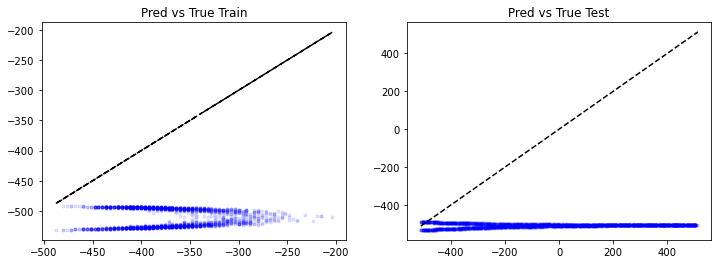

In [23]:
plt.rcParams["figure.figsize"]= [12,4]
fig,(ax0,ax1)=plt.subplots(1,2)
plot_sets(ax0,ax1,[0,0,1])
ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
plt.show()

# Comparing results at different epochs

tensor(541.1735)


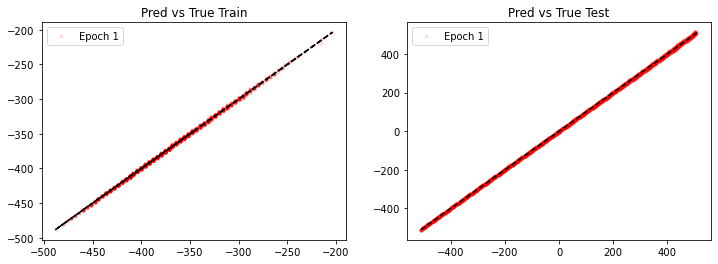

tensor(541.1735)


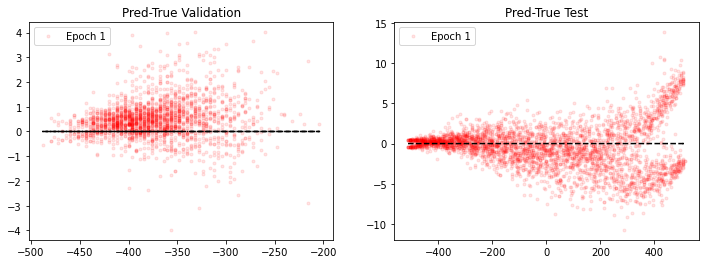

541.1734619140625


In [24]:
fig,(ax0,ax1)=plt.subplots(1,2)

colors = [[1,0,0],[0,1,0],[0,0,1]]
for i in range(epoch):
    net = torch.load("models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    #net.setup()
    torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    plot_sets(ax0,ax1,colors[i],name='Epoch %d'%(i+1))


ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
ax0.legend()
ax1.legend()
plt.show()

fig,(ax0,ax1)=plt.subplots(1,2)

for i in range(epoch):
    net = torch.load("models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    #net.setup()
    OFF=plot_sets(ax0,ax1,colors[i],True,name='Epoch %d'%(i+1))
ax0.set_title("Pred-True Validation")
ax1.set_title("Pred-True Test")
ax0.legend()
ax1.legend()
plt.show()

OFF=OFF.item()
print(OFF)

# Using the RNN as a generator

In [25]:
def d2genstates(net,p,nstates):
    """ Generates a set of Ising configurations sampled using the RNNs predictions.
    Parameters:
        net (LSTM2dCell)         - The RNN network. For now this has to be a 2D rnn
        p   (Float or 2D tensor) - Probability modifier involved in choosing spin values when generating states.
            If this is set to 1, spin values are sampled according the the RNN probability labels
            If this is set to inf, spin values are assigned by taking what is most probable (This will minimize energy)
            If this is set to -inf, spin values are assigned by taking what is least probable (This will maximize energy)
            If p is a tensor, it should have shape [nstates,1]
        nstates (int)            - The number of states to generate in parallel
    """
    #def expmap(p,s=0.81873075307,d=0.777993681245,c=-0.2,k=3.2):
        #return (-np.e**(-k*p+c)+p/2+s)*d
    #p = expmap(p)
    #print(p)
    N=net.N
    X,Y,Z=net.X,net.Y,net.Z
    #set up array to store hidden states
    H,C= [True]*N**2,[True]*N**2
    #set the starting state to zero
    input = torch.zeros([nstates,N**2-1,1],device=device)
    label = torch.zeros([nstates,N**2-1,1],device=device)
    sample = (torch.rand([nstates,1],device=device)<0.5).to(torch.float32)
    input[:,0,:] = sample
    
    H[N*(N-1)]=C[N*(N-1)]=torch.zeros([nstates,net.state_dim],device=device)
    out = torch.zeros(input.shape,device=device)
    read=[]
    with torch.no_grad():
      for idx in range(N**2-1):
        #get horizontal input states
        hx,cx=H[X[idx]],C[X[idx]]
        #get vertical input states
        hy,cy=H[Y[idx]],C[Y[idx]]
        #get output states
        cnext,hnext=net.forward_pass(sample,hx,hy,cx,cy)
        input[:,idx,:]=sample
        #store output states for later use
        C[Z[idx]],H[Z[idx]] = cnext,hnext
        #apply linear layer
        
        probs=net.lin(hnext)
        
        out[:,idx,:]=probs
        
        weighed =0.5+p*(probs-0.5) #probs*p+(1-probs)*(1-p)
        sample = (torch.rand([nstates,1],device=device)<weighed).to(torch.float32)
        label[:,idx,:]=sample
        
    return input,label,out

def prob2e(data,real,pred,off):
    """Calculates predicted Energies using the input, output, and rnn prediciton vectors"""
    #get min and max E values
    ones = real*pred
    zeros=(1-real)*(1-pred)
    total = ones+zeros
    #this is the sum you see in the cell above
    prob=torch.sum(torch.log(total),dim=1).squeeze(1)-np.log(2)
    relE=-prob/B
    return(relE-off)

# Mapping Energies to values of p

The idea of how to do this is pretty simple

1. Take the map from p to E (which is not injective)
2. Take an subsection [a,b] such that p $\in$ [a,b] -> E(p) is injective
3. Invert this section with a fully connected network to get p(E)

In [32]:
def E2p(off,epoch=5000,start=-15,mid=-3,end=1.5):
    # Simple fully connected model
    e_pnet=nn.Sequential(
        nn.Linear(1, 20),
        nn.Tanh(),
        nn.Linear(20, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.Tanh(),
        nn.Linear(64, 32),
        nn.Tanh(),
        nn.Linear(32, 1)
    ).to(device)
    
    #set up model for training
    optimizer = torch.optim.Adam(
        e_pnet.parameters(), 
        lr= 1e-3, 
        betas=(beta1,beta2)
    )
    lossF=nn.MSELoss()
    losses=[]
    
    #Find minimum and maximum energies
    min_e=prob2e(*d2genstates(net,1000,1024),off).min()
    max_e=prob2e(*d2genstates(net,-1000,1024),off).max()
    
    # Get a map of E(p)
    pvals=torch.zeros([200])
    pvals[:100]=torch.linspace(start,mid,100)
    pvals[100:]=torch.linspace(mid,end,100)
    averages=torch.zeros([pvals.shape[0]])
    variances=torch.zeros([pvals.shape[0]])
    for i in range(pvals.shape[0]):
        if i%20==0:
            print(i//20,end='|')
        variances[i],averages[i] = torch.var_mean(prob2e(*d2genstates(net,pvals[i],1024),off))

    plt.errorbar(pvals,averages,variances**0.5,label="True P-Vals")
    plt.legend()
    plt.show()

    plt.plot(pvals,torch.log(variances))
    plt.show()
    plt.plot(averages,pvals)
    plt.title("Inverse of E(p)")
    plt.show()
    # Ask the user for an invertable subsection
    print("Please remove sections where E(p) maps p to multiple values")
    print("what is a good invertable range for E(p)?")
    pmin=float(input("P min: "))
    pmax=float(input("P max: "))
    #obtain this section
    xs=[]
    ys=[]
    vs=[]
    for i in range(pvals.shape[0]-1):
        if pmin<pvals[i] and pmax>pvals[i]:
            xs+=[averages[i]]
            ys+=[pvals[i]]
            vs+=[variances[i]]
    plt.plot(xs,ys)
    plt.show()
    #Make traindata to get p(E)
    DATA=torch.tensor(xs).to(device).unsqueeze(1)
    LABEL=torch.tensor(ys).to(device).unsqueeze(1)
    stdv=torch.tensor(vs).to(device).unsqueeze(1)**0.5
    print(len(DATA))
    print(torch.normal(mean=DATA,std=stdv)[::10,0])
    print(DATA[::10,0])
    
    
    # Now train the network to get p(E)
    for i in range(epoch+1):
        pred=e_pnet(torch.normal(mean=DATA,std=stdv/10))
        loss=lossF(pred,LABEL)
        e_pnet.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())
        if epoch//5==0 or i%(epoch//5)==0:
            tst = torch.linspace(min_e,max_e,1024,device=device).unsqueeze(1)
            out_=e_pnet(tst)
            label = prob2e(*d2genstates(net,out_,1024),off).unsqueeze(1)
            plt.plot(tst.squeeze(1).cpu(),label.squeeze(1).cpu())
            plt.plot(tst.squeeze(1).cpu(),tst.squeeze(1).cpu(),'k--')
            plt.show()

    #print(out_.shape,out_2.shape,label.shape) 
    
    plt.plot(np.arange(len(losses)),losses,'.',color=(0,0,1,0.2))
    plt.yscale("log")
    plt.show()
    plt.close()
    return [min_e,max_e],e_pnet

0|1|2|3|4|5|6|7|8|9|

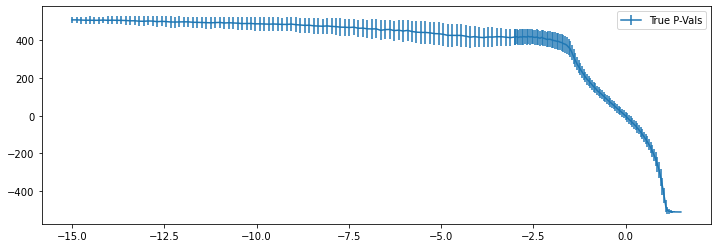

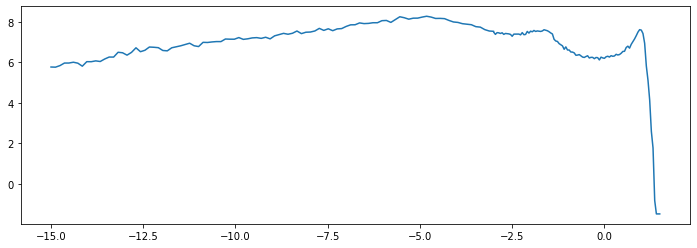

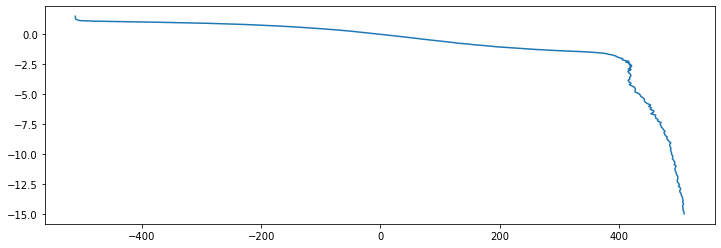

Please remove sections where E(p) maps p to multiple values
what is a good invertable range for E(p)?
P min: -15
P max: 1.2


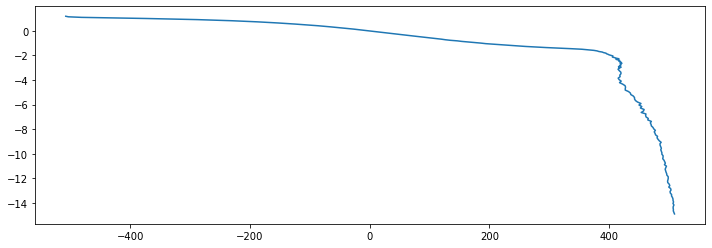

192
tensor([ 514.6538,  509.2697,  458.9065,  517.9105,  506.2002,  538.2489,
         460.5307,  431.3964,  455.5044,  482.9338,  381.8311,  360.0944,
         426.6562,  434.1613,  259.3600,  100.8901,   46.8578,  -68.0446,
        -229.0196, -477.8162], device='cuda:0')
tensor([ 509.5536,  507.0160,  500.5961,  493.9535,  488.4472,  482.0721,
         470.4023,  458.7670,  436.5524,  417.0536,  420.3953,  417.8781,
         406.6453,  374.6779,  219.7942,  119.9244,   39.1357,  -45.2095,
        -169.8871, -503.9105], device='cuda:0')


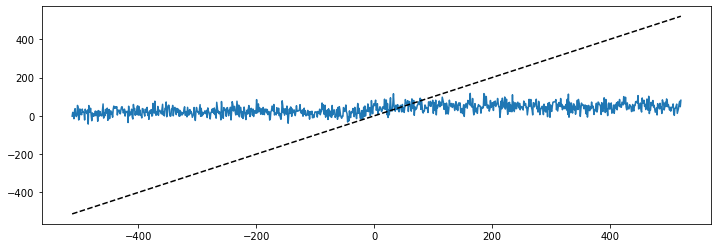

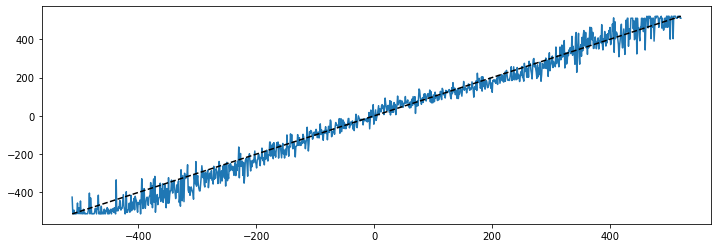

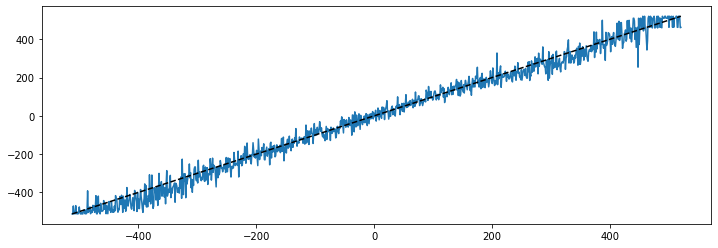

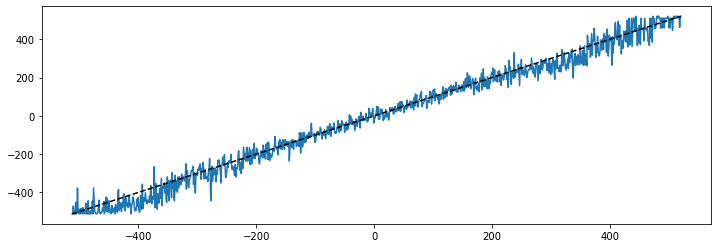

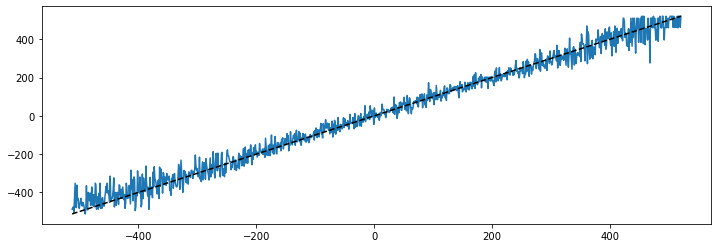

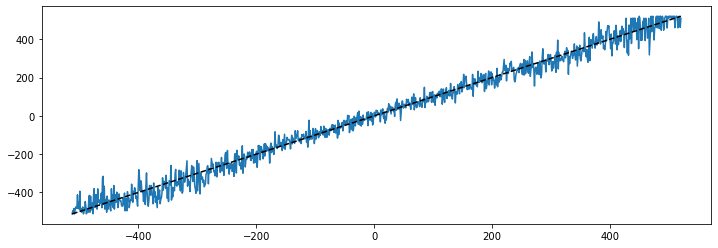

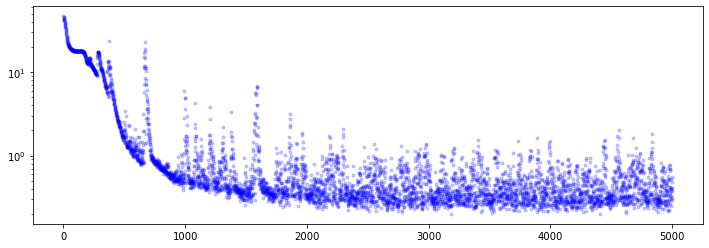

In [33]:
bounds,epnet = E2p(OFF,epoch=5000)

# Requesting states of a given energy

We can now request states of a given energy by using our map p(E)

1. For your energy request take p($E_{req}$)
2. Generate states s(p) with p (this step is stochastic)
3. Label states with $E_{true}(s)$ and verify $E_{req} \approx E_{true}$

In [34]:
tst = torch.linspace(*bounds,100,device=device).unsqueeze(1)
out_=epnet(tst)
pvals=out_.squeeze(1).detach().cpu()
averages=torch.zeros([pvals.shape[0]])
variances=torch.zeros([pvals.shape[0]])
for i in range(pvals.shape[0]):
    variances[i],averages[i] = torch.var_mean(prob2e(*d2genstates(net,pvals[i],512),OFF))
    


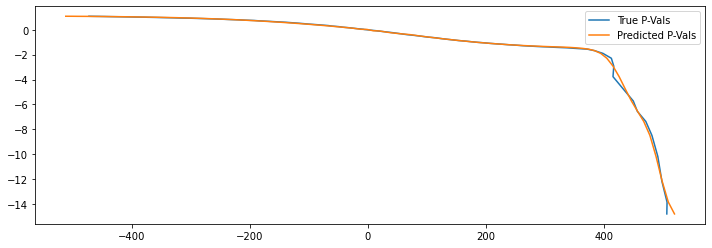

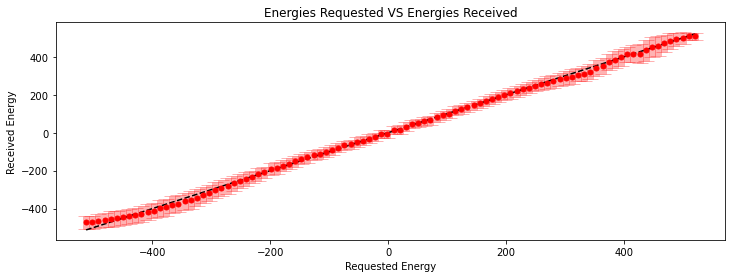

In [55]:
plt.plot(averages,pvals,label="True P-Vals")

plt.plot(tst.squeeze(1).detach().cpu(),out_.squeeze(1).detach().cpu(),label="Predicted P-Vals")
plt.legend()

plt.show()
plt.errorbar(tst.squeeze(1).detach().cpu(),averages,variances**0.5,
             color='r',marker='.',linestyle='',ecolor=(1,0,0,0.3),
             capsize=8,elinewidth=7,ms=10)

plt.plot(tst.squeeze(1).detach().cpu(),tst.squeeze(1).detach().cpu(),'k--')
plt.title("Energies Requested VS Energies Received")
plt.xlabel("Requested Energy")
plt.ylabel("Received Energy")
plt.show()